In [1]:
import os
import numpy as np
import pandas as pd
from skimage import io, color,img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import cv2
import seaborn as sns
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score,average_precision_score
import pickle

/tmp/ipykernel_24579/3904593019.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:


def co_occurrence_matrix(image_path, distances=[1, 5, 20], levels=256):
    # Load the image
    # image = io.imread(image_path)
    
    image = image_path
    # Check if the image has an alpha channel; if so, drop it
    if image.shape[-1] == 4:
        image = image[..., :3]  # Keep only the first three channels (RGB)

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
        
    # Quantize the image to the specified levels
    image = (image * (levels - 1)).astype(np.uint8)
    
    # Define angles for 0, 45, 90, 135 degrees in radians
    angles = [0, np.pi/4, np.pi/2] 
    # Calculate the GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    return glcm

def calculate_color_histogram(image, bins=256, channel_mask=[True, True, True]):
    # Calculate histograms for each channel
    histograms = []
    for i in range(3):  # Assuming the image has three channels (RGB)
        if channel_mask[i]:
            hist, _ = np.histogram(image[:, :, i], bins=bins, range=(0, 256), density=True)
            histograms.append(hist)
        else:
            histograms.append(np.zeros(bins))  # Append zeros if channel is masked
    return np.concatenate(histograms)

def calculate_texture_features(glcm):
    # Initialize a dictionary to store aggregated features
    features = {

    }
    # Number of directions
    num_directions = glcm.shape[2]
    num_anles = glcm.shape[3]
    
    # Compute features for each direction and average them
    for j in range(num_directions):
        for k in range(num_anles):
            features[f'Contrast_{j}_{k}'] = graycoprops(glcm, 'contrast',)[j, k]
            # features[f'Correlation_{j}_{k}'] = graycoprops(glcm, 'correlation')[j, k]
            # features[f'Energy_{j}_{k}'] = graycoprops(glcm, 'energy')[j, k]
            features[f'Homogeneity_{j}_{k}'] = graycoprops(glcm, 'homogeneity')[j, k]
            # features[f'ASM_{j}_{k}'] = graycoprops(glcm, 'ASM')[j, k]
            features[f'Dissimilarity_{j}_{k}'] = graycoprops(glcm, 'dissimilarity')[j, k]
            entropy = -np.sum(glcm[:, :, j, k] * np.log2(glcm[:, :, j, k] + 1e-10))
            features[f'Entropy_{j}_{k}'] = entropy

    # Average the features over the number of directions
    for key in features:
        features[key] /= num_directions

    return features

def lbglcm_calculator(image_url ,radius = 3  ):
    # image = io.imread(image_url)
    image = image_url
    # Check if the image has an alpha channel; if so, drop it
    if image.shape[-1] == 4:
        image = image[..., :3]  # Keep only the first three channels (RGB
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image_gray = color.rgb2gray(image)
    else :
        image_gray = image
    
    # image_gray = img_as_ubyte(rgb2gray(image))

    n_points = 8 * radius 

    lbp_image = local_binary_pattern(image_gray, n_points, radius, method="uniform")

    lbglcm = graycomatrix(lbp_image.astype(np.uint8), distances=[1, 5, 20], angles = [0, np.pi/4, np.pi/2] , levels=256)
    return lbglcm

def calculate_texture_features_lbglcm(lbglcm):
    # Initialize a dictionary to store aggregated features
    features = {

    }
    # Number of directions
    num_directions = lbglcm.shape[2]
    num_anles = lbglcm.shape[3]
    
    # Compute features for each direction and average them
    for j in range(num_directions):
        for k in range(num_anles):
            features[f'lbglcm_Contrast_{j}_{k}'] = graycoprops(lbglcm, 'contrast',)[j, k]
            # features[f'lbglcm_Correlation_{j}_{k}'] = graycoprops(lbglcm, 'correlation')[j, k]
            # features[f'lbglcm_Energy_{j}_{k}'] = graycoprops(lbglcm, 'energy')[j, k]
            features[f'lbglcm_Homogeneity_{j}_{k}'] = graycoprops(lbglcm, 'homogeneity')[j, k]
            # features[f'lbglcm_ASM_{j}_{k}'] = graycoprops(lbglcm, 'ASM')[j, k]
            features[f'lbglcm_Dissimilarity_{j}_{k}'] = graycoprops(lbglcm, 'dissimilarity')[j, k]
            entropy = -np.sum(lbglcm[:, :, j, k] * np.log2(lbglcm[:, :, j, k] + 1e-10))
            features[f'lbglcm_Entropy_{j}_{k}'] = entropy

    # Average the features over the number of directions
    for key in features:
        features[key] /= num_directions

    return features



def calculate_glrlm(image, levels=256):
    # Check if image is RGBA, if so, convert to RGB
    if image.shape[-1] == 4:
        image = image[..., :3]  # Discard alpha channel

    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        image = color.rgb2gray(image)

    # Ensure the image is in the correct format
    image = img_as_ubyte(image)

    # Initialize the GLRLM matrix
    max_run_length = image.shape[1]  # maximum run length possible is the number of columns
    glrlm = np.zeros((levels, max_run_length), dtype=int)
    
    # Calculate GLRLM
    for i in range(image.shape[0]):  # for each row
        run_length = 0
        previous_value = image[i, 0]
        for j in range(image.shape[1]):  # for each column
            if image[i, j] == previous_value:
                run_length += 1
            else:
                if run_length > 0:
                    glrlm[previous_value, run_length - 1] += 1
                run_length = 1
                previous_value = image[i, j]
        if run_length > 0:
            glrlm[previous_value, run_length - 1] += 1  # For the last run in the row

    return glrlm

def short_runs_emphasis(glrlm):
    # Calculate Short Runs Emphasis
    j = np.arange(1, glrlm.shape[1] + 1)
    denominator = np.sum(glrlm)
    numerator = np.sum(glrlm / j**2, axis=(0, 1))  # sum over both dimensions
    return numerator / denominator if denominator != 0 else 0

def process_image(image_path):
    try:
        image = io.imread(image_path)
        if image.shape[-1] == 4:
            image = image[..., :3]

        co_occ = co_occurrence_matrix(image, levels=256)
        lbglcm = lbglcm_calculator(image)
        glrlm = calculate_glrlm(image)
        sre = short_runs_emphasis(glrlm)

        features = calculate_texture_features(co_occ)
        features.update(calculate_texture_features_lbglcm(lbglcm))
        features['short_runs_emphasis'] = sre
        # features['Class'] = os.path.basename(os.path.dirname(image_path))
        return features
    except Exception as e:
        print(f"Failed to process {image_path}: {e}")
        return None

In [2]:

# # Collect data
# image_folder = './train'
# features_df = collect_features_from_images(image_folder)
# features_df.to_csv('image_features.csv', index=False)

# Load data from CSV
from sklearn.discriminant_analysis import StandardScaler


data = pd.read_csv('train_Ai_image_features_notall.csv')
X = data.drop('Class', axis=1)

y = data['Class']

data2 = pd.read_csv('test_Ai_image_features_notall.csv')
X_t = data2.drop('Class', axis=1)

y_t = data2['Class']

# # Scale data
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X_t = scaler.transform(X_t)

# Split data into training and testing sets
X_train,_, y_train ,_= train_test_split(X, y, train_size=0.99 , random_state=42)

X_test, _, y_test  ,_ = train_test_split(X_t, y_t,  train_size=0.99, random_state=42)
# Train SVM classifier


In [4]:
Xmin = X.min()
Xmax = X.max()


In [5]:
X_train.head(5)

,Contrast_0_0,Homogeneity_0_0,Dissimilarity_0_0,Entropy_0_0,Contrast_0_1,Homogeneity_0_1,Dissimilarity_0_1,Entropy_0_1,Contrast_0_2,Homogeneity_0_2,...,lbglcm_Entropy_2_0,lbglcm_Contrast_2_1,lbglcm_Homogeneity_2_1,lbglcm_Dissimilarity_2_1,lbglcm_Entropy_2_1,lbglcm_Contrast_2_2,lbglcm_Homogeneity_2_2,lbglcm_Dissimilarity_2_2,lbglcm_Entropy_2_2,short_runs_emphasis
97646,528.694731,0.093562,7.727000,3.859437,624.955659,0.087449,8.761886,3.906281,504.089884,0.095095,...,-5.112645e+06,42.545623,0.163274,2.199358,-5.076028e+06,41.989159,0.169073,2.152355,-5.130407e+06,0.946925
47844,20.296115,0.189150,0.854334,3.617642,32.353806,0.163574,1.118600,3.751520,18.531603,0.194147,...,-6.706056e+06,29.079727,0.074942,2.328341,-6.676835e+06,28.847825,0.076662,2.304308,-6.747040e+06,0.788668
43483,134.484852,0.186857,2.237864,3.682657,171.409876,0.170493,2.625007,3.777501,80.195048,0.199765,...,-4.428970e+06,36.811250,0.108207,2.455697,-4.419485e+06,36.064135,0.112448,2.396555,-4.492375e+06,0.825403
26192,15.684652,0.201822,0.763166,3.489490,27.434464,0.173280,1.066536,3.644966,16.824880,0.191510,...,-6.789181e+06,34.079149,0.082153,2.523570,-6.712106e+06,33.226984,0.085400,2.456903,-6.742823e+06,0.783392
8114,53.547135,0.201109,1.322102,3.546967,85.892660,0.186217,1.649163,3.633750,47.093559,0.205174,...,-7.040010e+06,34.739192,0.105902,2.397259,-7.015896e+06,34.326364,0.108788,2.361511,-7.094791e+06,0.801446


In [ ]:
def plot_pairplot(df):
    pairplot = sns.pairplot(df, hue='Class', markers=["o", "s"], palette='bright')
    pairplot.fig.suptitle('Pair Plot of Texture Features', y=1.02)
    plt.show()
plot_pairplot(data)

In [6]:
#MinMax Scaling

normalized_X = (X - X.min()) / (X.max() - X.min())
normalized_X_t = (X_t - X.min()) / (X.max() - X.min())


In [7]:
normalized_X.head(5)


,Contrast_0_0,Homogeneity_0_0,Dissimilarity_0_0,Entropy_0_0,Contrast_0_1,Homogeneity_0_1,Dissimilarity_0_1,Entropy_0_1,Contrast_0_2,Homogeneity_0_2,...,lbglcm_Entropy_2_0,lbglcm_Contrast_2_1,lbglcm_Homogeneity_2_1,lbglcm_Dissimilarity_2_1,lbglcm_Entropy_2_1,lbglcm_Contrast_2_2,lbglcm_Homogeneity_2_2,lbglcm_Dissimilarity_2_2,lbglcm_Entropy_2_2,short_runs_emphasis
0,0.021963,0.613650,0.067927,0.682383,0.018891,0.599015,0.057537,0.680171,0.015083,0.649123,...,0.930534,0.521611,0.260474,0.729484,0.930446,0.531012,0.253541,0.751406,0.929925,0.730914
1,0.008636,0.624670,0.039197,0.651912,0.018358,0.537497,0.058124,0.684265,0.013872,0.588330,...,0.926511,0.509756,0.237163,0.729939,0.927045,0.512576,0.241716,0.739159,0.926929,0.675347
2,0.010455,0.821933,0.030081,0.367015,0.012315,0.801986,0.030326,0.372236,0.007520,0.841994,...,0.938831,0.276773,0.557288,0.407284,0.938547,0.267407,0.579157,0.394469,0.937483,0.677934
3,0.007622,0.757858,0.028258,0.580915,0.011582,0.669757,0.035606,0.609295,0.009855,0.727687,...,0.937005,0.381833,0.160219,0.663521,0.937162,0.384663,0.164599,0.672604,0.936603,0.533358
4,0.019795,0.592891,0.061964,0.632054,0.020259,0.551826,0.059205,0.639933,0.012079,0.645935,...,0.926636,0.500732,0.250585,0.720163,0.926631,0.496849,0.261761,0.716720,0.926056,0.722626


In [8]:
normalized_X_t.head(5)

,Contrast_0_0,Homogeneity_0_0,Dissimilarity_0_0,Entropy_0_0,Contrast_0_1,Homogeneity_0_1,Dissimilarity_0_1,Entropy_0_1,Contrast_0_2,Homogeneity_0_2,...,lbglcm_Entropy_2_0,lbglcm_Contrast_2_1,lbglcm_Homogeneity_2_1,lbglcm_Dissimilarity_2_1,lbglcm_Entropy_2_1,lbglcm_Contrast_2_2,lbglcm_Homogeneity_2_2,lbglcm_Dissimilarity_2_2,lbglcm_Entropy_2_2,short_runs_emphasis
0,0.010359,0.570413,0.048556,0.711519,0.011483,0.501798,0.049538,0.727958,0.009039,0.572450,...,0.926924,0.479143,0.148464,0.753824,0.927291,0.487369,0.145839,0.772787,0.927263,0.702544
1,0.035979,0.224525,0.132269,0.804815,0.043926,0.183065,0.137193,0.814015,0.034042,0.245373,...,0.980720,0.737981,0.191417,0.923772,0.980680,0.741564,0.190265,0.937737,0.980424,0.899993
2,0.010017,0.618523,0.050631,0.632986,0.015802,0.549009,0.063615,0.658276,0.014524,0.597052,...,0.971483,0.496130,0.298506,0.690254,0.971724,0.495125,0.297221,0.697704,0.971481,0.784314
3,0.013695,0.845704,0.031460,0.326028,0.018285,0.824613,0.037029,0.334347,0.010402,0.855310,...,0.919404,0.220867,0.622495,0.340397,0.919506,0.218014,0.634550,0.336568,0.918625,0.681142
4,0.013303,0.801236,0.036032,0.560247,0.015773,0.757689,0.037446,0.574345,0.011446,0.795647,...,0.930157,0.344378,0.288270,0.584367,0.930254,0.349281,0.288014,0.597086,0.929730,0.583832


In [9]:
X_norm = normalized_X
X_test_norm = normalized_X_t

X_train,_, y_train ,_= train_test_split(X_norm, y, train_size=0.99 , random_state=42)

X_test, _, y_test  ,_ = train_test_split(X_test_norm, y_t,  train_size=0.99, random_state=42)
# Train SVM classifier

In [10]:
X_test.shape

(49413, 73)

In [11]:
clf1 = svm.SVC(kernel='rbf', degree=64, C=15000.0, cache_size=2000,verbose=True)
clf1.fit(X_train, y_train)

# Predict and evaluate the classifier
predictions = clf1.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions,digits=4))
print("Accuracy:", accuracy_score(y_test, predictions))

[LibSVM].................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
*...............................................................................................................*.............................................................................................................................................................................................................................................................................................................................................................................................................

In [79]:
y_test

49060    FAKE
44967    FAKE
16416    REAL
28889    FAKE
38998    FAKE
         ... 
11284    REAL
44732    FAKE
38158    FAKE
860      REAL
15795    REAL
Name: Class, Length: 49413, dtype: object

In [15]:
predictions.shape

(49413,)

In [17]:
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder

# Assuming y_test and predictions are provided as shown
# Convert string labels to binary labels
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)
predictions_binary = label_encoder.transform(predictions)

# Calculate the Mean Average Precision (mAP)
mAP = average_precision_score(y_test_binary, predictions_binary)
print("\nMean Average Precision (mAP):", mAP)


Mean Average Precision (mAP): 0.9666670621868568


In [28]:
y_test_binary

array([0, 0, 1, ..., 0, 1, 1])

In [29]:
predictions_binary

array([0, 0, 1, ..., 0, 1, 1])

In [31]:
from sklearn.metrics import f1_score
label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)
predictions_binary = label_encoder.transform(predictions)

print("Accuracy:", accuracy_score(y_test, predictions))

mAP = average_precision_score(y_test_binary, predictions_binary)
print("Mean Average Precision (mAP):", mAP)
# Calculate the F1 score
f1 = f1_score(y_test_binary, predictions_binary, pos_label=label_encoder.transform(['REAL'])[0])
print("\nF1 Score:", f1)

Accuracy: 0.9732661445368628
Mean Average Precision (mAP): 0.9666670621868568

F1 Score: 0.9729928648825465


In [20]:
pickle.dump(clf1, open('SVM.sav', 'wb'))

In [3]:
clfLoad = pickle.load(open("SVM.sav", 'rb'))

In [4]:
clfLoad.predict(X_test)

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'REAL', 'REAL'], dtype=object)

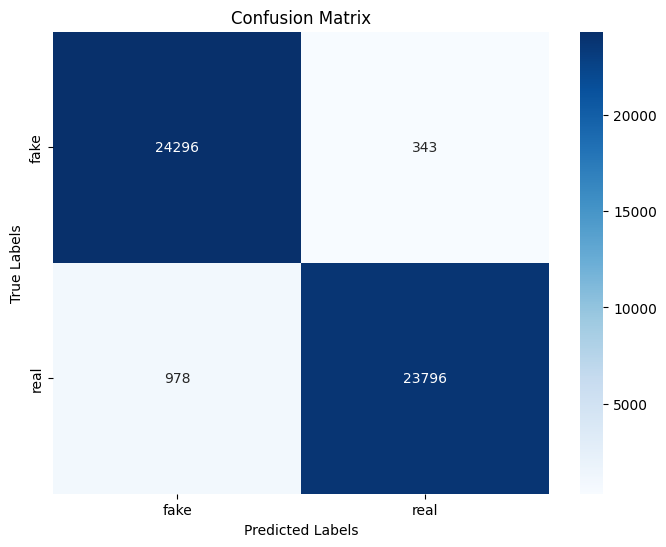

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
y_pred_svm = clfLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('SVM_confusion_matrix_Raw.png')
plt.show()

In [36]:

# Create a DecisionTreeClassifier object
clf2 = DecisionTreeClassifier(random_state=64,criterion='entropy')

# Fit the classifier to the training data
clf2.fit(X_train, y_train)
# Calculate the accuracy of the model
y_pred = clf2.predict(X_test)


# Detailed classification report
print(classification_report(y_test, y_pred,digits=4))
accuracy = accuracy_score(y_test, y_pred)
print(f"DecisionTree Accuracy: {accuracy}")

# print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

        FAKE     0.9747    0.9830    0.9788     24639
        REAL     0.9829    0.9747    0.9788     24774

    accuracy                         0.9788     49413
   macro avg     0.9788    0.9788    0.9788     49413
weighted avg     0.9788    0.9788    0.9788     49413

DecisionTree Accuracy: 0.9787910064153158


In [38]:
pickle.dump(clf2, open('DT.sav', 'wb'))

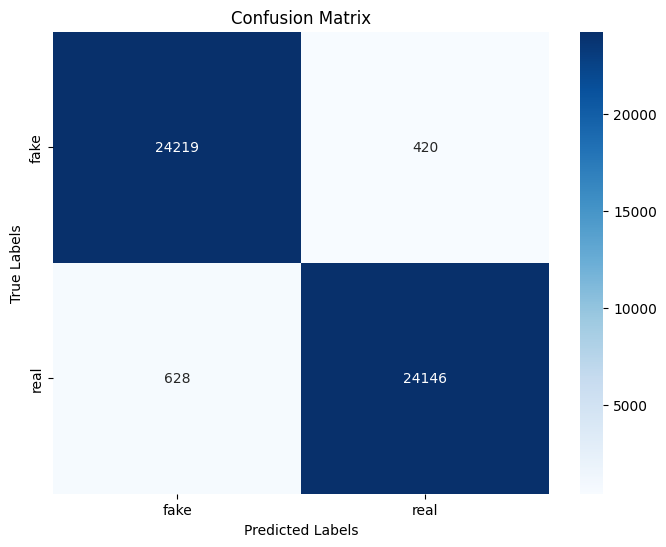

In [7]:
DTLoad = pickle.load(open("DT.sav", 'rb'))
y_pred_svm = DTLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('DT_confusion_matrix_Raw.png')
plt.show()

In [39]:
DTLoad = pickle.load(open("DT.sav", 'rb'))
y_pred_DT = DTLoad.predict(X_test)
# Detailed classification repor
print(classification_report(y_test, y_pred_DT,digits=4))

              precision    recall  f1-score   support

        FAKE     0.9747    0.9830    0.9788     24639
        REAL     0.9829    0.9747    0.9788     24774

    accuracy                         0.9788     49413
   macro avg     0.9788    0.9788    0.9788     49413
weighted avg     0.9788    0.9788    0.9788     49413



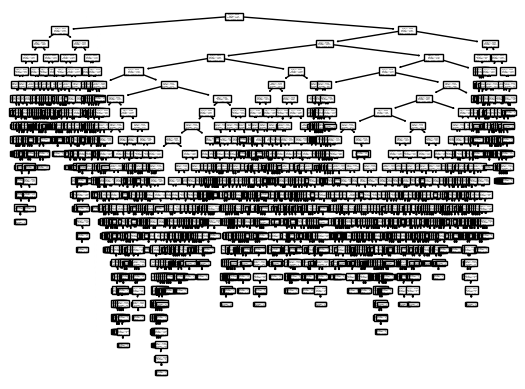

In [14]:


tree.plot_tree(clf2)
plt.show()

In [26]:
!pip install xgboost

/bin/bash: /home/mayoi/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 8.5 MB/s eta 0:00:00:00:0100:01


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=42)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

print(classification_report(y_test, y_pred_gbc))
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gbc))

In [9]:

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


print(classification_report(y_test, y_pred_rf,digits=4))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

        FAKE     0.9753    0.9920    0.9836     24639
        REAL     0.9920    0.9750    0.9834     24774

    accuracy                         0.9835     49413
   macro avg     0.9836    0.9835    0.9835     49413
weighted avg     0.9836    0.9835    0.9835     49413

Random Forest Accuracy: 0.9835063647218343


In [10]:
pickle.dump(rf, open('rf.sav', 'wb'))

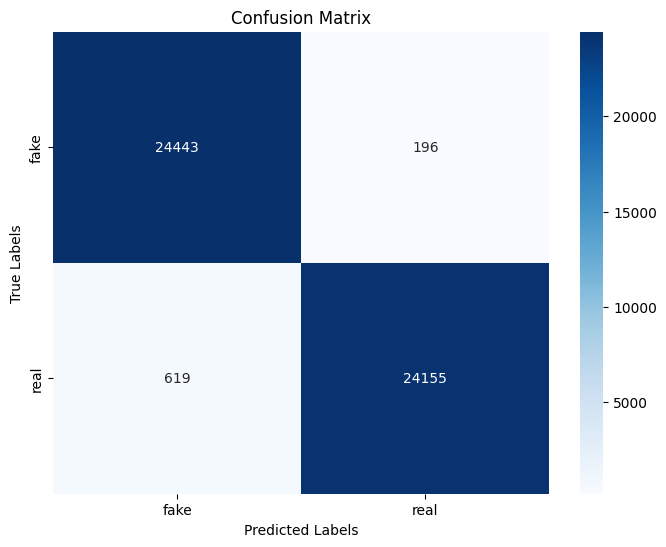

In [11]:
RFLoad = pickle.load(open("rf.sav", 'rb'))
y_pred_svm = RFLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Random_Forest_confusion_matrix_Raw.png')
plt.show()

In [13]:

gnb = GaussianNB(var_smoothing=32.12e-8)
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)

print(classification_report(y_test, y_pred_nb, digits=4))
print("Gaussian Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

              precision    recall  f1-score   support

        FAKE     0.7653    0.9538    0.8492     24639
        REAL     0.9391    0.7090    0.8080     24774

    accuracy                         0.8311     49413
   macro avg     0.8522    0.8314    0.8286     49413
weighted avg     0.8524    0.8311    0.8285     49413

Gaussian Naive Bayes Accuracy: 0.8310768421265659


In [14]:
pickle.dump(gnb, open('gnb.sav', 'wb'))

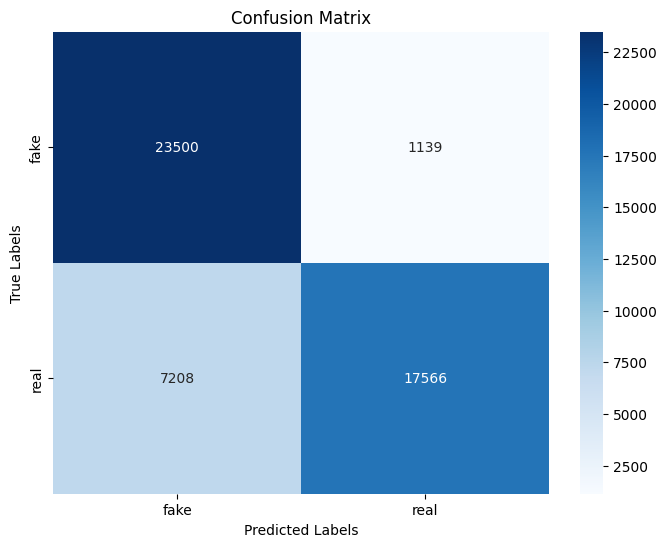

In [15]:
RFLoad = pickle.load(open("gnb.sav", 'rb'))
y_pred_svm = RFLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('gnb_confusion_matrix_Raw.png')
plt.show()

In [17]:
#KNN 

from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, weights='distance' , metric='euclidean',algorithm='kd_tree')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn,digits=4))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

              precision    recall  f1-score   support

        FAKE     0.9849    0.9910    0.9879     24639
        REAL     0.9910    0.9849    0.9879     24774

    accuracy                         0.9879     49413
   macro avg     0.9879    0.9879    0.9879     49413
weighted avg     0.9880    0.9879    0.9879     49413

KNN Accuracy: 0.9879383967781757


In [18]:
pickle.dump(knn, open('knn.sav', 'wb'))

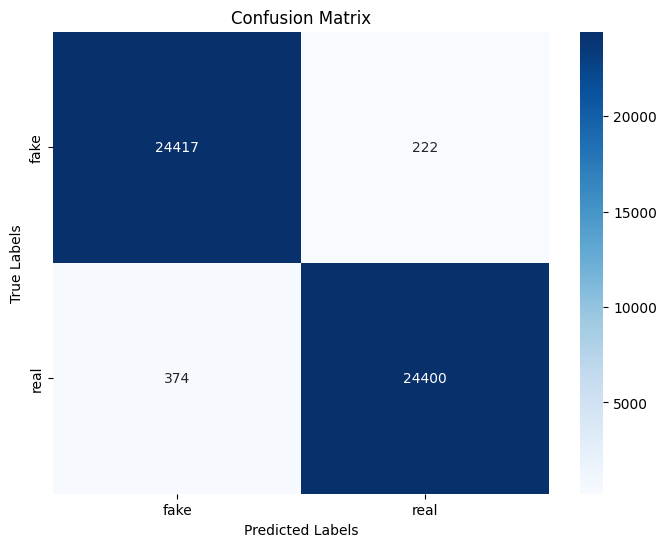

In [19]:
KNNLoad = pickle.load(open("knn.sav", 'rb'))
y_pred_svm = KNNLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Knn_confusion_matrix_Raw.png')
plt.show()

In [57]:
from sklearn.neural_network import MLPClassifier
mlp =  MLPClassifier(random_state=42, max_iter=300)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print(classification_report(y_test, y_pred_mlp,digits=4))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))


              precision    recall  f1-score   support

        FAKE     0.8381    0.3482    0.4920     24639
        REAL     0.5901    0.9331    0.7230     24774

    accuracy                         0.6415     49413
   macro avg     0.7141    0.6407    0.6075     49413
weighted avg     0.7138    0.6415    0.6078     49413

KNN Accuracy: 0.641470867990205


In [73]:
pickle.dump(mlp, open('MLP.sav', 'wb'))

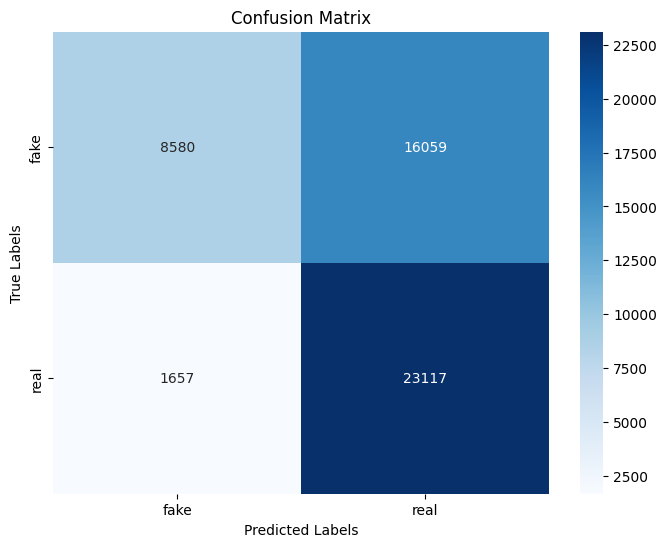

In [20]:
MLPLoad = pickle.load(open("MLP.sav", 'rb'))
y_pred_svm = MLPLoad.predict(X_test)
confusion_matrix(y_test,y_pred_svm)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('mlp_confusion_matrix_Raw.png')
plt.show()

In [60]:
from sklearn.neural_network import MLPClassifier
mlp =  MLPClassifier(random_state=42, max_iter=800)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print(classification_report(y_test, y_pred_mlp,digits=4))
print("MLP Accuracy:", accuracy_score(y_test, y_pred_mlp))

              precision    recall  f1-score   support

        FAKE     0.8381    0.3482    0.4920     24639
        REAL     0.5901    0.9331    0.7230     24774

    accuracy                         0.6415     49413
   macro avg     0.7141    0.6407    0.6075     49413
weighted avg     0.7138    0.6415    0.6078     49413

MLP Accuracy: 0.641470867990205


In [56]:


eclf = VotingClassifier( estimators=[('svm', clf1),('dt', clf1), ('rf', rf), ('gnb', gnb),('knn',knn)], voting='hard')
for clf, label in zip([clf1, clf2, rf,gnb, knn ,eclf], ['svm', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.00) [Logistic Regression]
Accuracy: 0.97 (+/- 0.00) [Random Forest]
Accuracy: 0.98 (+/- 0.00) [naive Bayes]
Accuracy: 0.83 (+/- 0.01) [Ensemble]


/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[[57.27268772372938, 0.18794217225462392, 1.4967731691433335, 3.7296587419183376, 115.69807501789073, 0.1527629516518565, 2.3276108576200962, 3.9531944301965076, 78.5380833539501, 0.1763919707696919, 1.7856419477500707, 3.808902338252689, 328.5104623933961, 0.0980209409600864, 4.845977028060575, 4.335631133979484, 438.54283539894186, 0.08017549054819513, 6.059619727391865, 4.467685414610212, 408.28821792546654, 0.0852992891918292, 5.6771919638626, 4.4294220897742465, 873.8997364566244, 0.04019430267086286, 10.439117548729994, 4.784952077324551, 1045.1566222320469, 0.033695147572522025, 11.798727539008036, 4.844732916214323, 1016.9388988344443, 0.033528424576042055, 11.645950830136185, 4.842129001498273, 24.090897875021923, 0.1517478256565984, 1.6307948561761985, -8351286.742590395, 30.29117736222211, 0.12244376481514925, 2.032465333742464, -8164342.283938818, 26.075517511692187, 0.14121491184874854, 1.7610990793887005, -8279340.371974592, 37.04809931138876, 0.09468162714222528, 2.50707

In [66]:


clf1 = svm.SVC(kernel='rbf', degree=64, C=15000.0, coef0=0.1)
clf2 = DecisionTreeClassifier(random_state=64)
gnb = GaussianNB(var_smoothing=1e-7)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

eclf = VotingClassifier( estimators=[('svm', clf1),('dt', clf1), ('rf', rf), ('gnb', gnb),('knn',knn)], voting='hard',n_jobs=16,verbose=True)
eclf.fit(X_train,y_train)

y_pred_eclf= eclf.predict(X_test)


print(classification_report(y_test, y_pred_eclf,digits=4))
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_eclf))

[Voting] ...................... (5 of 5) Processing knn, total=   0.1s
[Voting] ...................... (4 of 5) Processing gnb, total=   0.2s
[Voting] ....................... (3 of 5) Processing rf, total= 2.4min
[Voting] ....................... (2 of 5) Processing dt, total= 5.5min
[Voting] ...................... (1 of 5) Processing svm, total= 5.5min
              precision    recall  f1-score   support

        FAKE     0.9627    0.9876    0.9750     24639
        REAL     0.9873    0.9620    0.9745     24774

    accuracy                         0.9747     49413
   macro avg     0.9750    0.9748    0.9747     49413
weighted avg     0.9751    0.9747    0.9747     49413

Ensemble Accuracy: 0.9747434885556433


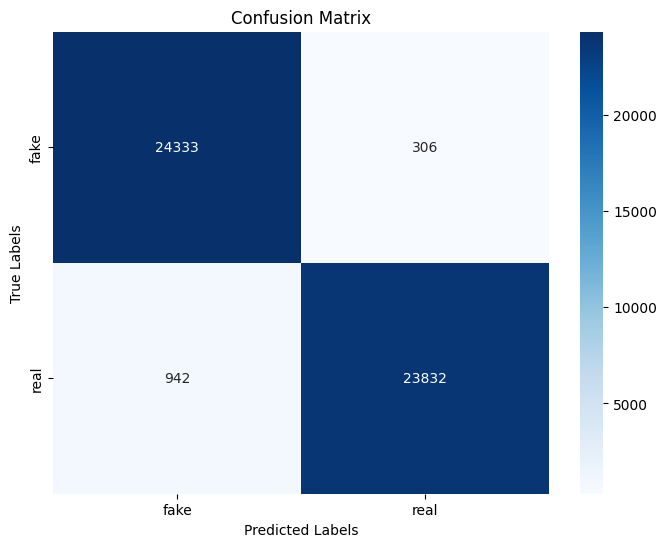

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix(y_test,y_pred_eclf)
#plot confusion matrix
cm = confusion_matrix(y_test,y_pred_eclf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('EMs_confusion_matrix_Raw.png')
plt.show()

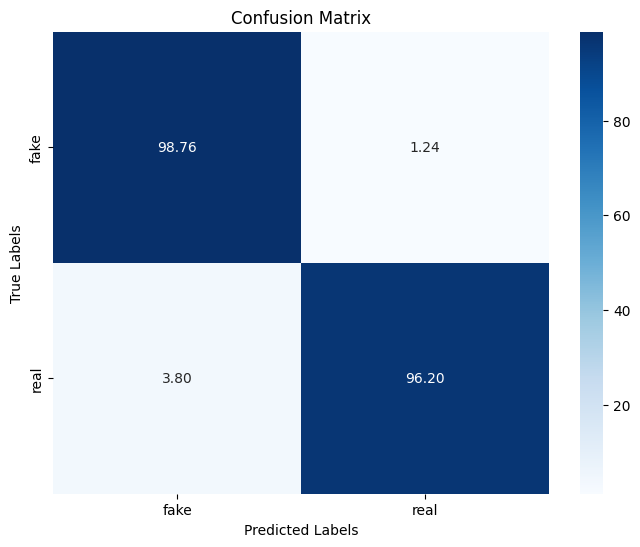

In [51]:
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.2f', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('EMs_confusion_matrix_Precent.png')
plt.show()

In [14]:
eclf.predict(input)

/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array(['FAKE'], dtype=object)

In [67]:
import pickle

In [47]:


filename = 'Ensemble_P_model_FuLL.sav'


In [48]:
pickle.dump(eclf, open(filename, 'wb'))


In [49]:
image_path = 'real4.jpg'
input = [list(process_image(image_path).values())]
print(input)

/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[[19.96856625830304, 0.2623308889755551, 0.6600185136017231, 2.658078580767158, 43.7776380275433, 0.2494017158145595, 0.9443252727694239, 2.7543807027186102, 28.77554627450938, 0.26351988008164146, 0.7171941313218695, 2.6580562699755643, 163.8619739199963, 0.21319409808335588, 2.2086732543387444, 3.014474309150005, 209.77513853660005, 0.2054918778780748, 2.4919612588630318, 3.0572807958788846, 187.74217955033524, 0.21405194952486348, 2.281968289708372, 3.0128478474602893, 572.094870982936, 0.15754918893505107, 5.6196770086690355, 3.3997353842562448, 558.688958156387, 0.15585395552613682, 5.405987741940451, 3.395523926852412, 546.3609684265438, 0.1562462201998521, 5.334087938383187, 3.3917773310947035, 13.106684521414573, 0.21782972081020494, 0.9453446119328165, -110615772.1861093, 17.11646683302259, 0.19113588678185814, 1.2393953356503, -108680511.84117305, 13.435725058344387, 0.21622369409039136, 0.9637156016003027, -110488111.87035716, 21.63512303432309, 0.16857329337035631, 1.585255

In [19]:
X.min()

Contrast_0_0                3.309004e-01
Homogeneity_0_0             8.307104e-03
Dissimilarity_0_0           6.746274e-02
Entropy_0_0                 2.615045e-01
Contrast_0_1                5.046723e-01
                                ...     
lbglcm_Contrast_2_2         2.945889e+00
lbglcm_Homogeneity_2_2      4.999242e-02
lbglcm_Dissimilarity_2_2    2.103967e-01
lbglcm_Entropy_2_2         -9.230131e+07
short_runs_emphasis         3.601368e-01
Length: 73, dtype: float64

In [23]:
y_pred = process_image(image_path)

/home/mayoi/anaconda3/envs/tf/lib/python3.9/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [25]:
input_df = pd.DataFrame(y_pred, index=[0])

In [26]:
input_df

,Contrast_0_0,Homogeneity_0_0,Dissimilarity_0_0,Entropy_0_0,Contrast_0_1,Homogeneity_0_1,Dissimilarity_0_1,Entropy_0_1,Contrast_0_2,Homogeneity_0_2,...,lbglcm_Entropy_2_0,lbglcm_Contrast_2_1,lbglcm_Homogeneity_2_1,lbglcm_Dissimilarity_2_1,lbglcm_Entropy_2_1,lbglcm_Contrast_2_2,lbglcm_Homogeneity_2_2,lbglcm_Dissimilarity_2_2,lbglcm_Entropy_2_2,short_runs_emphasis
0,19.968566,0.262331,0.660019,2.658079,43.777638,0.249402,0.944325,2.754381,28.775546,0.26352,...,-1.051941e+08,24.078011,0.143871,1.807841,-1.046830e+08,23.93307,0.145249,1.793816,-1.048258e+08,0.729953


In [33]:
normalized_input = (input_df-X.min())/(X.max()-X.min())
normalized_input

,Contrast_0_0,Homogeneity_0_0,Dissimilarity_0_0,Entropy_0_0,Contrast_0_1,Homogeneity_0_1,Dissimilarity_0_1,Entropy_0_1,Contrast_0_2,Homogeneity_0_2,...,lbglcm_Entropy_2_0,lbglcm_Contrast_2_1,lbglcm_Homogeneity_2_1,lbglcm_Dissimilarity_2_1,lbglcm_Entropy_2_1,lbglcm_Contrast_2_2,lbglcm_Homogeneity_2_2,lbglcm_Dissimilarity_2_2,lbglcm_Entropy_2_2,short_runs_emphasis
0,0.006781,0.80648,0.027436,0.492971,0.01163,0.769219,0.03262,0.507256,0.010173,0.813218,...,-0.138716,0.329012,0.363566,0.532225,-0.137302,0.331685,0.36417,0.540924,-0.136334,0.583501


In [52]:
loaded_model = pickle.load(open(filename, 'rb'))

In [37]:
loaded_model = pickle.load(open(filename, 'rb'))

result = loaded_model.predict(X_test)

print(result)

['FAKE']


In [53]:
result = loaded_model.predict(X_test)
print(result)

['FAKE' 'FAKE' 'REAL' ... 'FAKE' 'REAL' 'REAL']
